In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 128, 64, 4, len(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.keras.backend as K

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=4, width=128, height=64):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

Text(0.5, 1.0, 'EDBL')

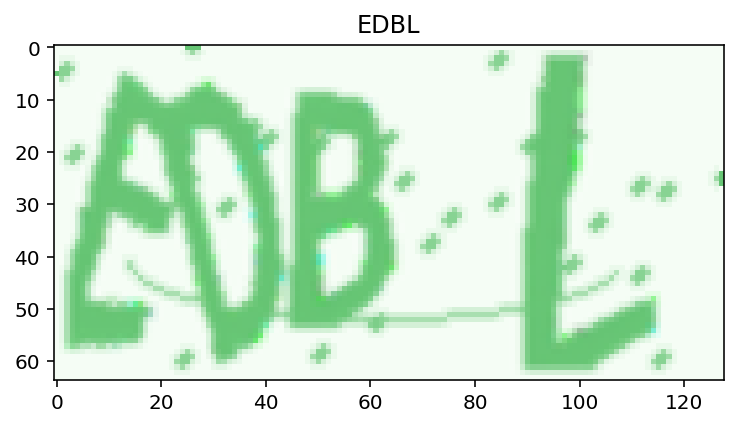

In [4]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

data = CaptchaSequence(characters, batch_size=1, steps=1)
X, y = data[0]
plt.imshow(X[0])
plt.title(decode(y))

In [5]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128, steps=1000)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100)
callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4,
                    callbacks=callbacks)

C:\Users\Akshitha\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/100
1000/1000 [==============================] - ETA: 0s - batch: 499.5000 - size: 128.0000 - loss: 4.4491 - c1_loss: 1.0554 - c2_loss: 1.1814 - c3_loss: 1.1753 - c4_loss: 1.0369 - c1_acc: 0.7090 - c2_acc: 0.6738 - c3_acc: 0.6749 - c4_acc: 0.7121

C:\Users\Akshitha\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 3888s 4s/step - batch: 499.5000 - size: 128.0000 - loss: 4.4491 - c1_loss: 1.0554 - c2_loss: 1.1814 - c3_loss: 1.1753 - c4_loss: 1.0369 - c1_acc: 0.7090 - c2_acc: 0.6738 - c3_acc: 0.6749 - c4_acc: 0.7121 - val_loss: 1.6317 - val_c1_loss: 0.2587 - val_c2_loss: 0.5545 - val_c3_loss: 0.5052 - val_c4_loss: 0.3132 - val_c1_acc: 0.9187 - val_c2_acc: 0.8632 - val_c3_acc: 0.8597 - val_c4_acc: 0.9035
Epoch 2/100
1000/1000 [==============================] - 6398s 6s/step - batch: 499.5000 - size: 128.0000 - loss: 0.2309 - c1_loss: 0.0446 - c2_loss: 0.0709 - c3_loss: 0.0701 - c4_loss: 0.0452 - c1_acc: 0.9845 - c2_acc: 0.9765 - c3_acc: 0.9771 - c4_acc: 0.9846 - val_loss: 0.3226 - val_c1_loss: 0.0547 - val_c2_loss: 0.1101 - val_c3_loss: 0.1018 - val_c4_loss: 0.0560 - val_c1_acc: 0.9808 - val_c2_acc: 0.9654 - val_c3_acc: 0.9673 - val_c4_acc: 0.9803
Epoch 3/100
1000/1000 [==============================] - 16580s 17s/step - batch: 499.5000 - size: 128.0000 

In [6]:
model.load_weights('alpha_num.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


(-0.5, 127.5, 63.5, -0.5)

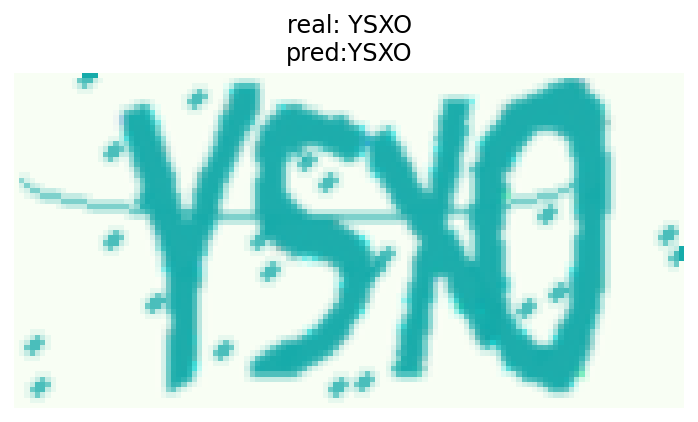

In [7]:
X, y = data[0]
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

In [11]:
from tqdm import tqdm
def evaluate(model, batch_num=100):
    batch_acc = 0
    with tqdm(CaptchaSequence(characters, batch_size=128, steps=100)) as pbar:
        for X, y in pbar:
            y_pred = model.predict(X)
            y_pred = np.argmax(y_pred, axis=-1).T
            y_true = np.argmax(y, axis=-1).T

            batch_acc += (y_true == y_pred).all(axis=-1).mean()
    return batch_acc / batch_num


evaluate(model)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [12:30<00:00,  7.50s/it]


0.96640625

<AxesSubplot:>

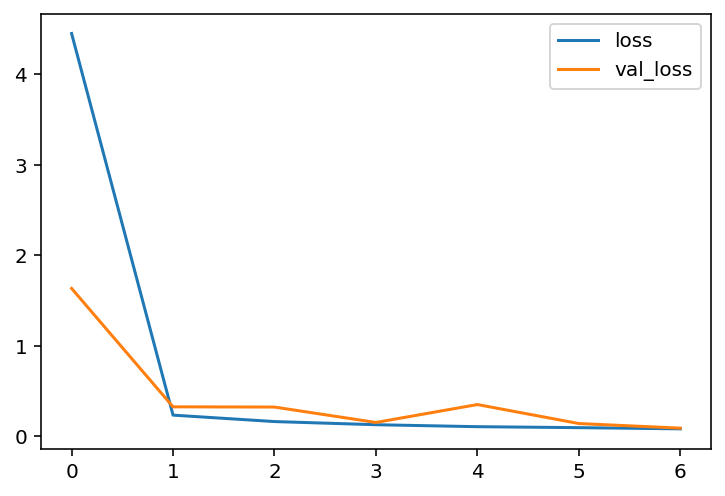

In [8]:
import pandas as pd

df = pd.read_csv('cnn.csv')
df[['loss', 'val_loss']].plot()